# Project 2: Linear Classification

### Part 1: Generate Training and Testing Data (2 points)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Generating Training and Testing Data
# Creating a class for the dataset
class Data_set:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov  = cov
    
    def split_data(self):
        np.random.shuffle(self.data)
        self.train = self.data[:len(self.data)//2]
        self.test  = self.data[len(self.data)//2:]
        
        return self
    
    def multivariate_normal(self, num):
        # asself.data.shape = num *  2
        self.data = np.random.multivariate_normal(self.mean,self.cov,size=num)
    
        return self
    
def accuracy(data, w, b):
    false_count = 0
    miss_data    = []
    for index, item in enumerate(data):
        lda_val = np.dot(w,item)
        # class c1
        if index<100 and lda_val<0:
            false_count = false_count + 1
            miss_data   = np.append(miss_data, item)
        # class c2    
        elif index>=100 and lda_val>=0:
            false_count = false_count + 1
            miss_data   = np.append(miss_data, item)
    
    accuracy = 1 - false_count/len(data)
    miss_data = miss_data.reshape(int(len(miss_data)/2),2)
#     print(miss_data.shape)
    
    return accuracy, miss_data



In [2]:
#### Given parameters
mean1 = np.array([1,1])
mean2 = np.array([-1,-1])
cov1 = np.array([[3,2],[2,3]])
cov2 = np.array([[2,-1],[-1,2]])

#### Generating dataset and spliting dataset
c1 = Data_set(mean1,cov1)
c1 = c1.multivariate_normal(200)
c1 = c1.split_data()
# c1.train, c1.test
c2 = Data_set(mean2,cov2)
c2 = c2.multivariate_normal(200)
c2 = c2.split_data()


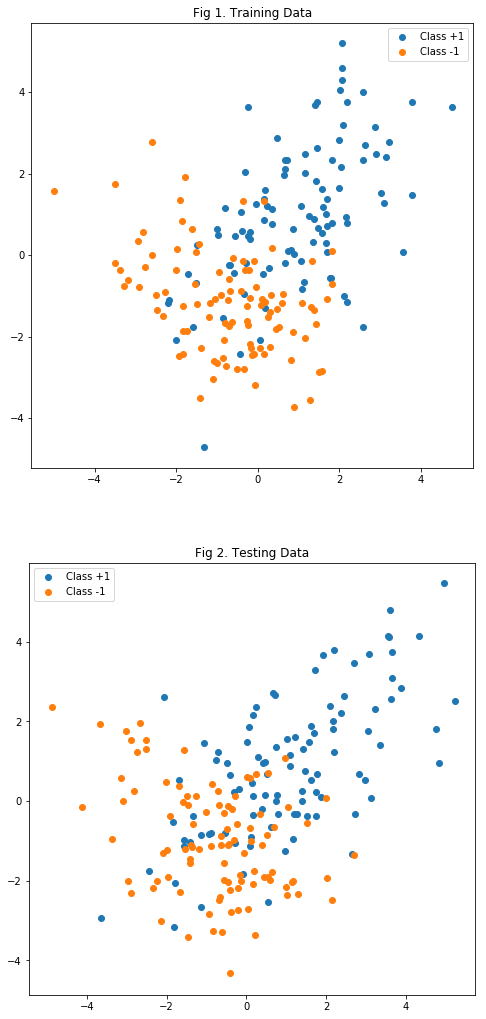

In [3]:
fig = plt.figure(1,figsize=(8,18))

ax_train = fig.add_subplot(211, aspect='equal')
ax_train.scatter(c1.train[:,0], c1.train[:,1], label="Class +1")
ax_train.scatter(c2.train[:,0], c2.train[:,1], label="Class -1")
ax_train.legend()
ax_train.set_title("Fig 1. Training Data")

ax_test  = fig.add_subplot(212, aspect='equal')
ax_test.scatter(c1.test[:,0], c1.test[:,1], label="Class +1")
ax_test.scatter(c2.test[:,0], c2.test[:,1], label="Class -1")
ax_test.legend()
ax_test.set_title("Fig 2. Testing Data")
plt.show()

### Part 2: Linear Discriminant Analysis (5 points)

In [4]:
# Overall mean & covariance
train_data = np.vstack((c1.train, c2.train))
test_data  = np.vstack((c1.test, c2.test))
# mu_est     = [np.mean(train_data[:,0]),np.mean(train_data[:,1])]
cov_est    = np.cov(test_data.T)   # Transopose data to get correct covariance
print("-----Output-----")
# print("The estimate overall mean is", mu_est)
print("The estimate overall covariance is", cov_est)

-----Output-----
The estimate overall covariance is [[3.54165925 1.5218637 ]
 [1.5218637  3.33792923]]


In [5]:
# Finding weight(w) vector
# w = (mu1 - mu2)*cov_est^T
sample_mean_c1 = np.array([np.mean(c1.train[:,0]),np.mean(c1.train[:,1])])
sample_mean_c2 = np.array([np.mean(c2.train[:,0]),np.mean(c2.train[:,1])])
w              = np.dot((sample_mean_c1 - sample_mean_c2),cov_est**-1)

pi_1           = len(c1.test)/len(test_data)
pi_2           = len(c2.test)/len(test_data)
# First two terms of bias
term1          = 0.5*np.dot(np.dot(sample_mean_c1.T, np.linalg.inv(cov_est)),sample_mean_c1)
term2          = 0.5*np.dot(np.dot(sample_mean_c2.T, np.linalg.inv(cov_est)),sample_mean_c2)

b              = term1 - term2 + np.log(pi_2/pi_1)

print("-----Learned weight and bias-----")
print("Learned weight w is", w)
print("Learned bias b is", b)

-----Learned weight and bias-----
Learned weight w is [1.8687694  1.74042637]
Learned bias b is -0.008666913486742284


-----Accuracy-----
The accuracy is 0.825


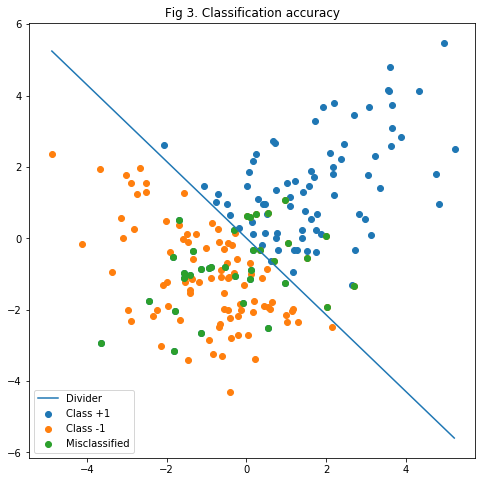

In [6]:
# Classify the test data
x_axis = np.arange(np.min(test_data[:,0]),np.max(test_data[:,0]),0.1)
y_axis = (-b-w[0]*x_axis)/w[1]

acc, miss = accuracy(test_data, w, b)
print("-----Accuracy-----")
print("The accuracy is", acc)

fig2 = plt.figure(2,figsize=(8,8))

ax2 = fig2.add_subplot(111)
ax2.scatter(c1.test[:,0], c1.test[:,1], label="Class +1")
ax2.scatter(c2.test[:,0], c2.test[:,1], label="Class -1")
ax2.scatter(miss[:,0], miss[:,1], label="Misclassified")
ax2.plot(x_axis,y_axis,label="Divider")
ax2.legend()
ax2.set_title("Fig 3. Classification accuracy")
plt.show()

### Part 3: Logistic Regression (10 points)

In [7]:
# Lump a '1' into each data point
ones          = np.ones(len(train_data))[None].T
train_data_1s = np.hstack((ones, train_data))

In [26]:
def IRLS(data):
    length        = len(data)
    not_converged = True
    w             = np.array([0.1, 0.1, 0.1])
    p             = np.empty(length)
    s             = np.empty(length)
    z             = np.empty(length)

    ones = np.ones(200)
    ones[100:200] = ones[100:200]*-1
    y = ones
    
#     while not_converged:
    for i in range(100):
        w_prev = w
        for i in range(len(data)):
            p[i] = (np.exp(np.dot(w, data[i].T)))/(1 + np.exp(np.dot(w, data[i])))
            s[i] = p[i] * (1 - p[i])
            z[i] = np.dot(w, data[i].T) + (y[i]-p[i])/(s[i])
        diag_s = np.diag(s)
        t1     = np.linalg.inv(np.dot(np.dot(data.T, diag_s), data))
        t2     = np.dot(np.dot(data.T, diag_s), z)
        w      = np.dot(t1, t2)
        
#         if abs(sum(w-w_prev)) < 0.1:
#             not_converged = True
            
    return w
        

In [27]:
IRLS(train_data_1s)

/home/campus07/peterzhu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


array([nan, nan, nan])

In [14]:
np.exp(np.dot(w, train_data[0]))

0.018800324610053123

In [28]:
np.exp(-1*1000)

0.0